In [1]:
from functools import wraps
import numpy as np
import pandas as pd
from scipy import integrate, optimize, stats
import matplotlib.pyplot as plt

## References

 - Gerardo Chowell, *Fitting dynamic models to epidemic outbreaks withquantified uncertainty: A primer for parameter uncertainty,identifiability, and forecasts*, KeAi Infectious Disease Modelling (2017) 379-398
 - Cécile Viboud, *A generalized-growth model to characterize the early ascendingphase of infectious disease outbreaks*, Elsevier Epidemics (2016) 27-37

### Useful Links

 
 - https://www.sciencedirect.com/science/article/pii/S2468042717300234
 - https://www.sciencedirect.com/science/article/pii/S1755436516000037
 - https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#scipy.integrate.solve_ivp
 - https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
 - https://stackoverflow.com/questions/60791453/how-can-i-fix-this-typeerror-when-fitting-ode-with-scipy
 
 

In [2]:
t = np.arange(0, 50)

## GRM


The Generalized Richards Model:

$$
\dot{C}(t) = r C^p\left[1-\left(\frac{C}{K}\right)^a\right]
$$

Where $C(t)$ is the cumulative number of case, $r \in \mathbb{R}^+$ is the **growth rate** and $p \in (0,1)$ is the **deceleration of growth**, $K \in \mathbb{R}^+$ is the **size of the epidemic** and $a$ is the deviation from the S-shaped dynamic.

In [3]:
def GRM_ODE(t, C, r, p, K, a):
    return r*np.power(C, p)*(1-np.power((C/K), a))

In [4]:
def GRM(t, C, r, p, K, a):
    return integrate.solve_ivp(GRM_ODE, (t[0], t[-1]), [C], t_eval=t, args=(r, p, K, a), rtol=1e-6).y[0]

In [5]:
y2 = GRM(t, 2, 1.15, 0.4, 2550, 0.89)

In [6]:
popt2, pcov2 = optimize.curve_fit(GRM, t, y2, bounds=([0.1, 0.1, 0.1, 50, 0.1], [10, 10, 1, 10000, 10]), gtol=1e-9)
(popt2, pcov2)

(array([2.00e+00, 1.15e+00, 4.00e-01, 2.55e+03, 8.90e-01]),
 array([[ 1.63428484e-28, -5.41812693e-29,  1.96369340e-29,
          9.07390858e-25, -3.19385848e-28],
        [-5.41812693e-29,  2.12511504e-29, -8.17893667e-30,
         -4.33412914e-25,  1.44790179e-28],
        [ 1.96369340e-29, -8.17893667e-30,  3.22555719e-30,
          1.81195662e-25, -5.91577267e-29],
        [ 9.07390858e-25, -4.33412914e-25,  1.81195662e-25,
          1.16864748e-20, -3.61322821e-24],
        [-3.19385848e-28,  1.44790179e-28, -5.91577267e-29,
         -3.61322821e-24,  1.14146363e-27]]))

In [7]:
y2f = GRM(t, *popt2)

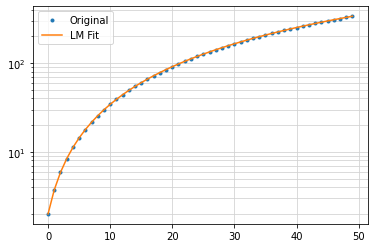

In [8]:
fig, axe = plt.subplots()
axe.semilogy(t, y2, '.', label='Original')
axe.semilogy(t, y2f, label='LM Fit')
axe.legend()
axe.grid(which='both', color='lightgray')

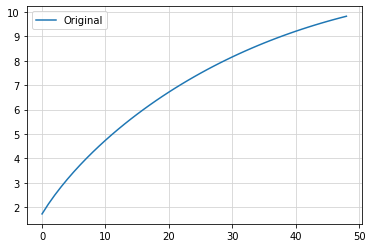

In [9]:
fig, axe = plt.subplots()
axe.plot(t[:-1], np.diff(y2)/np.diff(t), '-', label='Original')
#axe.semilogy(t, y2f, label='LM Fit')
axe.legend()
axe.grid(which='both', color='lightgray')

## Refactoring

### Factory for ODE

We create a factory for ODE adjustment

In [10]:
def ODEFitFactory(f):
    """
    Factory to adjust signature function of the Integrated ODE solved by scipy.integrate.solve_ivp
    to the optimizer provided by scipy.optimize.curve_fit
    The first argument args[0] is the initial condition of the IVP
    The rest of arguments args[1:] are parameters of the Fit
    """
    @wraps(f)
    def inner(t, *args):
        return integrate.solve_ivp(f, (t[0], t[-1]), args[0:], t_eval=t, args=args[1:]).y[0]
    return inner

In [11]:
def ODEFit(ode, x, y, p0=None, bounds=(-np.inf, np.inf)):
    """
    Fit ODE parameters using optimizer provided by scipy.optimize.curve_fit
    """
    odef = ODEFitFactory(ode)
    popt, pcov = optimize.curve_fit(odef, x, y, p0=p0, bounds=bounds)
    return popt, pcov